<a href="https://colab.research.google.com/github/Aryamaan777/Seq2Seq-Attention/blob/main/Seq2Seq%2BAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

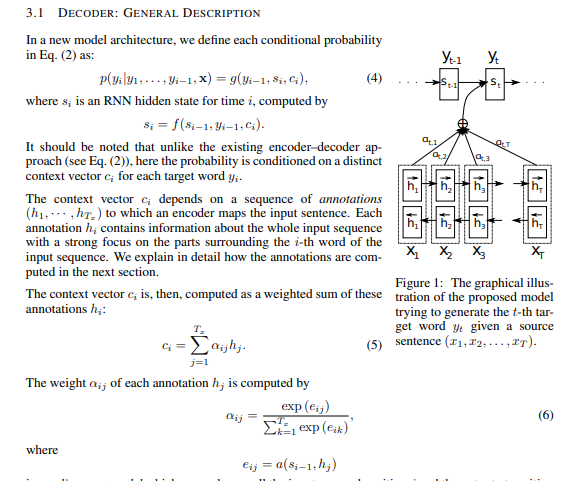

Encoder produces the output.
Context Vector produces the attention weights(values)[alpha(t,1)]
Encoder States, hidden and cell states from the encoder are provided as input to the decoder.

In [ ]:
!python -m spacy download de
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
#from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

In [ ]:
spacy_ger=spacy.load("de")
spacy_eng=spacy.load("en")

In [ ]:
def tokenize_ger(text):
  return [tok.text for tok in spacy_ger.tokenizer(text)]

def tokenize_eng(text):
  return [tok.text for tok in spacy_eng.tokenizer(text)]

In [ ]:
german=Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")
english=Field(tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
train_data, valid_data, test_data=Multi30k.splits(
    exts=(".de",".en"),
    fields=(german,english)
)

/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(Encoder, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    self.embedding=nn.Embedding(input_size, embedding_size)
    self.rnn=nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

    #hidden_size*2 because Bidirectional LSTM
    self.fc_hidden=nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell=nn.Linear(hidden_size*2,hidden_size)
    self.dropout=nn.Dropout(p)
  
  def forward(self,x):
    embedding=self.dropout(self.embedding(x))
    encoder_states, (hidden,cell)=self.rnn(embedding)

    #hidden[0:1] and hidden[1:2] are the forward and backward hidden states from the Bidirectional LSTM
    #Same with cell states
    #We concatenate them and provide them as input to the Fully Connected Layers
    hidden=self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
    cell=self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

    return encoder_states, hidden, cell

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    super(Decoder, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    self.embedding=nn.Embedding(input_size, embedding_size)
    #Input to the LSTM is the hidden state from the Encoder and the encoder_states from the Encoder
    self.rnn=nn.LSTM(hidden_size*2+embedding_size, hidden_size, num_layers)

    #Input to this layer is the hidden state from the Encoder(hidden_size*2) + hidden state from the Decoder(hidden_size), thus hidden_size*3
    self.energy=nn.Linear(hidden_size*3,1)
    self.fc=nn.Linear(hidden_size, output_size)
    self.dropout=nn.Dropout(p)
    self.softmax=nn.Softmax(dim=0)
    self.relu=nn.ReLU()

  def forward(self, x, encoder_states, hidden, cell):
    x=x.unsqueeze(0)

    embedding=self.dropout(self.embedding(x))

    sequence_length=encoder_states.shape[0]
    #Repeat the hidden_state sequence_length number of times
    h_reshaped=hidden.repeat(sequence_length,1,1)

    #Calculate Energy
    energy=self.relu(self.energy(torch.cat((h_reshaped,encoder_states), dim=2)))

    #Apply Softmax of Calculated Energy to get the attention
    attention=self.softmax(energy)

    #torch.bmm in the video
    #Basically Multiplication of the matrices in a way
    context_vector=torch.einsum("snk,snl->knl", attention, encoder_states)

    #Concatenate the Context Vector and Embedding output to get the Input of the RNN
    rnn_input=torch.cat((context_vector, embedding), dim=2)

    outputs, (hidden,cell)=self.rnn(rnn_input,(hidden,cell))

    predictions=self.fc(outputs).squeeze(0)

    return predictions, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq,self).__init__()
    self.encoder=encoder
    self.decoder=decoder

  #Teacher Force Ratio is the ratio of times we pass the actual value instead of the predicted value 
  def forward(self, source, target, teacher_force_ratio=0.5):
    batch_size=source.shape[1]
    target_len=target.shape[0]
    target_vocab_size=len(english.vocab)

    outputs=torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    encoder_states,hidden,cell=self.encoder(source)

    x=target[0]

    for t in range(1, target_len):
      output,hidden,cell=self.decoder(x, encoder_states, hidden, cell)
      outputs[t]=output

      best_guess=output.argmax(1)

      x=target[t] if random.random()<teacher_force_ratio else best_guess

    return outputs

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model=False
save_model=False

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
num_epochs=100
learning_rate=3e-4
batch_size=32

In [ ]:
input_size_encoder=len(german.vocab)
input_size_decoder=len(english.vocab)
output_size=len(english.vocab)
encoder_embedding_size=300
decoder_embedding_size=300
hidden_size=1024
num_layers=1
enc_dropout=0.0
dec_dropout=0.0

step=0

In [ ]:
train_iterator, valid_iterator, test_iterator=BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x:len(x.src),
    device=device
)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
encoder_net=Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=Decoder(input_size_decoder,decoder_embedding_size,hidden_size,output_size,num_layers,dec_dropout).to(device)

In [ ]:
model=Seq2Seq(encoder_net, decoder_net).to(device)
optimizer=optim.Adam(model.parameters(), lr=learning_rate)

pad_idx= english.vocab.stoi["<pad>"]
criterion=nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
sentence = (
    "ein boot mit mehreren männern darauf wird von einem großen"
    "pferdegespann ans ufer gezogen."
)

In [ ]:
for epoch in range(num_epochs):
  print(f"[Epoch {epoch} / {num_epochs}]")

  for batch_idx, batch in enumerate(train_iterator):
    inp_data=batch.src.to(device)
    target=batch.trg.to(device)

    output=model(inp_data,target)

    output=output[1:].reshape(-1, output.shape[2])
    target=target[1:].reshape(-1)

    optimizer.zero_grad()
    loss=criterion(output,target)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    optimizer.step()

    step+=1

[Epoch 0 / 100]
[Epoch 1 / 100]
[Epoch 2 / 100]
[Epoch 3 / 100]
[Epoch 4 / 100]
[Epoch 5 / 100]
[Epoch 6 / 100]
[Epoch 7 / 100]
[Epoch 8 / 100]
[Epoch 9 / 100]
[Epoch 10 / 100]
[Epoch 11 / 100]
[Epoch 12 / 100]
[Epoch 13 / 100]
[Epoch 14 / 100]
[Epoch 15 / 100]
[Epoch 16 / 100]
[Epoch 17 / 100]
[Epoch 18 / 100]
[Epoch 19 / 100]
[Epoch 20 / 100]
[Epoch 21 / 100]
[Epoch 22 / 100]
[Epoch 23 / 100]
[Epoch 24 / 100]
[Epoch 25 / 100]
[Epoch 26 / 100]
[Epoch 27 / 100]
[Epoch 28 / 100]
[Epoch 29 / 100]
[Epoch 30 / 100]
[Epoch 31 / 100]
[Epoch 32 / 100]
[Epoch 33 / 100]
[Epoch 34 / 100]
[Epoch 35 / 100]
[Epoch 36 / 100]
[Epoch 37 / 100]
[Epoch 38 / 100]
[Epoch 39 / 100]
[Epoch 40 / 100]
[Epoch 41 / 100]
[Epoch 42 / 100]
[Epoch 43 / 100]
[Epoch 44 / 100]
[Epoch 45 / 100]
[Epoch 46 / 100]
[Epoch 47 / 100]
[Epoch 48 / 100]
[Epoch 49 / 100]
[Epoch 50 / 100]
[Epoch 51 / 100]
[Epoch 52 / 100]
[Epoch 53 / 100]
[Epoch 54 / 100]
[Epoch 55 / 100]
[Epoch 56 / 100]
[Epoch 57 / 100]
[Epoch 58 / 100]
[Epoch 

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
checkpoint = {"state_dict":model.state_dict(), "optimizer": optimizer.state_dict()}
save_checkpoint(checkpoint)

=> Saving checkpoint


In [ ]:
!pip install --upgrade torchtext

     |████████████████████████████████| 7.0MB 16.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint

In [ ]:
load_checkpoint(torch.load("my_checkpoint.pth.tar",map_location=torch.device('cpu')), model, optimizer)

=> Loading checkpoint


In [ ]:
score=bleu(test_data, model, german, english, device)
print(f"Bleu Score: {score*100:.2f}")

Bleu Score: 25.26
